In [0]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [0]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('RELIANCE.NS.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(method = 'ffill')

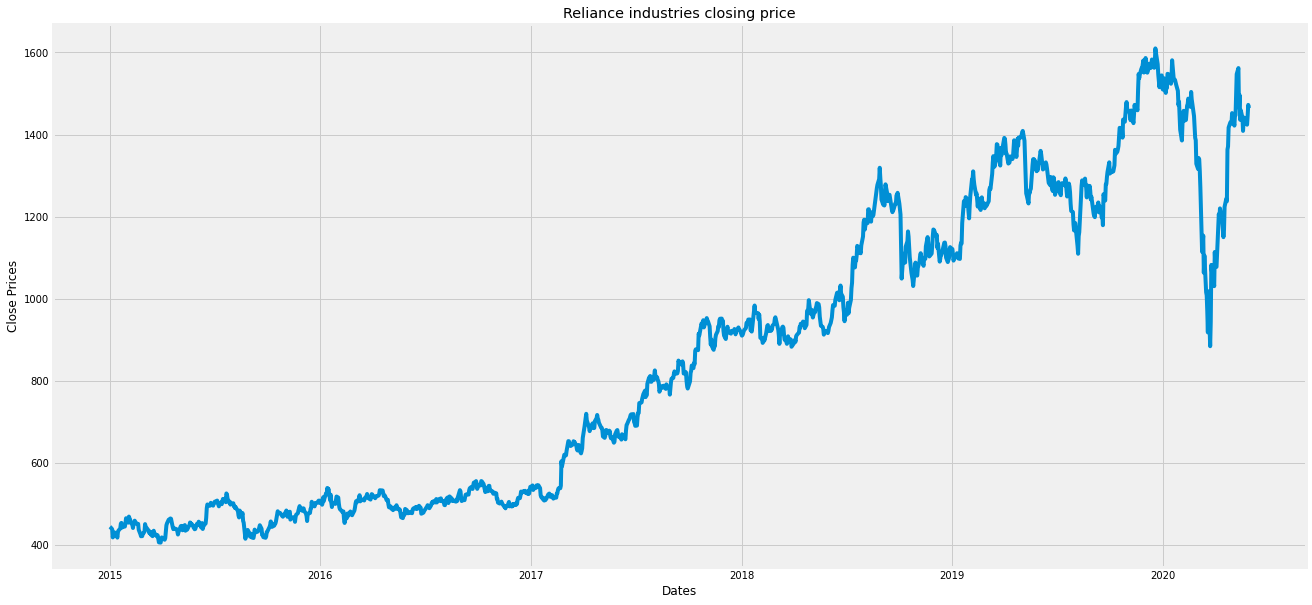

In [17]:
#plot close price
plt.figure(figsize=(20,10))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(data['Close'])
plt.title('Reliance industries closing price')
plt.show()  

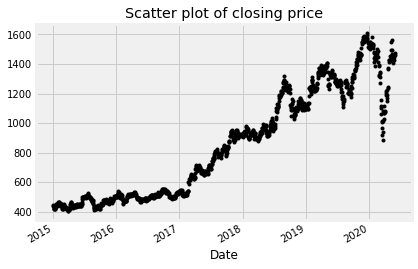

In [18]:
#scatter plot of the sales
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

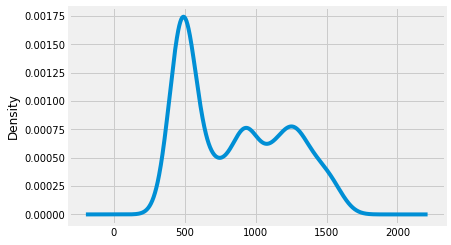

In [19]:
#Distribution of the dataset
df_close.plot(kind='kde')
#We can observe a near-normal distribution(bell-curve) over sales values.

In [0]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

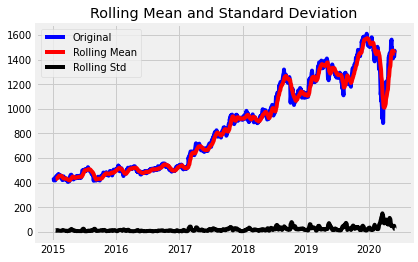

Results of dickey fuller test
Test Statistics                  -0.560842
p-value                           0.879587
No. of lags used                 21.000000
Number of observations used    1308.000000
critical value (1%)              -3.435359
critical value (5%)              -2.863752
critical value (10%)             -2.567948
dtype: float64


In [21]:
test_stationarity(df_close)

<Figure size 432x288 with 0 Axes>

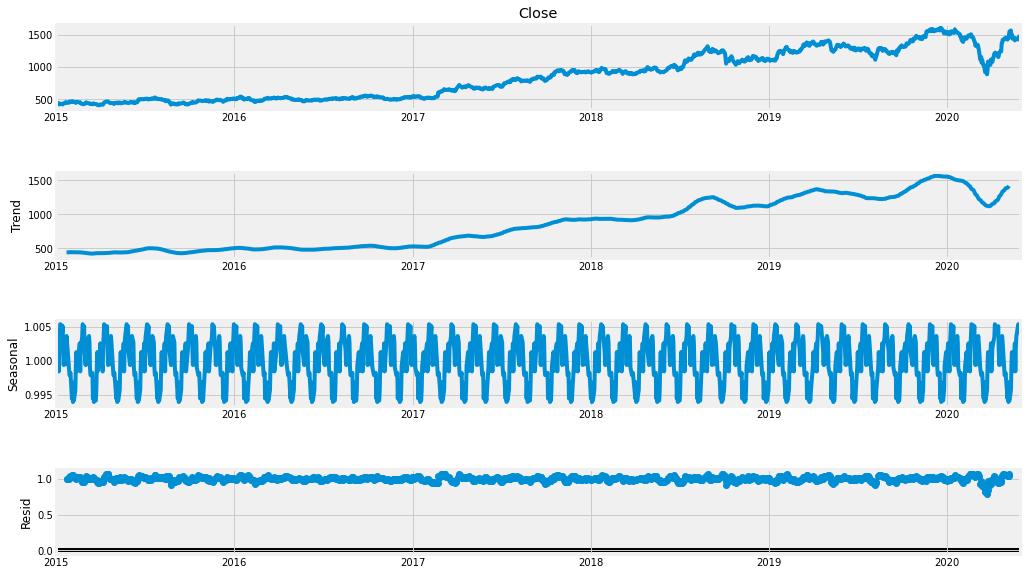

In [22]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


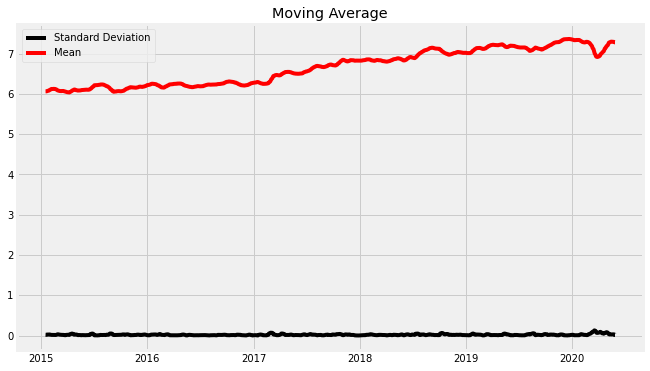

In [23]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

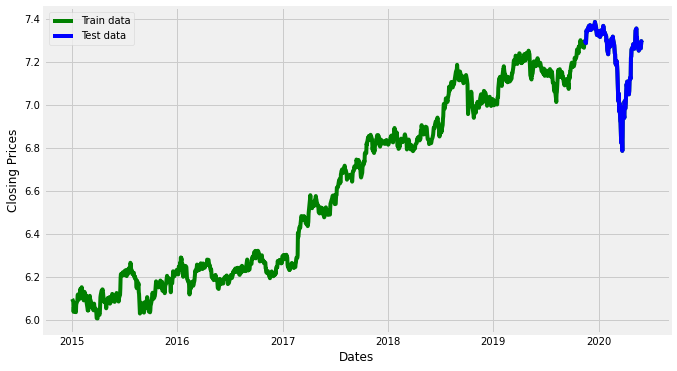

In [24]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [25]:
# Build Model
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1193
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3236.875
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sun, 07 Jun 2020   AIC                          -6459.751
Time:                        07:59:18   BIC                          -6424.161
Sample:                             1   HQIC                         -6446.341
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.000      2.123      0.034    8.11e-05       0.002
ar.L1.D.Close     0.0903      0.056      1.626      0.104      -0.019       0.199
ar.L2.D.Close    -0.9038      0.043    -

In [0]:
# Forecast
fc, se, conf = fitted.forecast(133, alpha=0.05)  # 95% conf

In [0]:
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

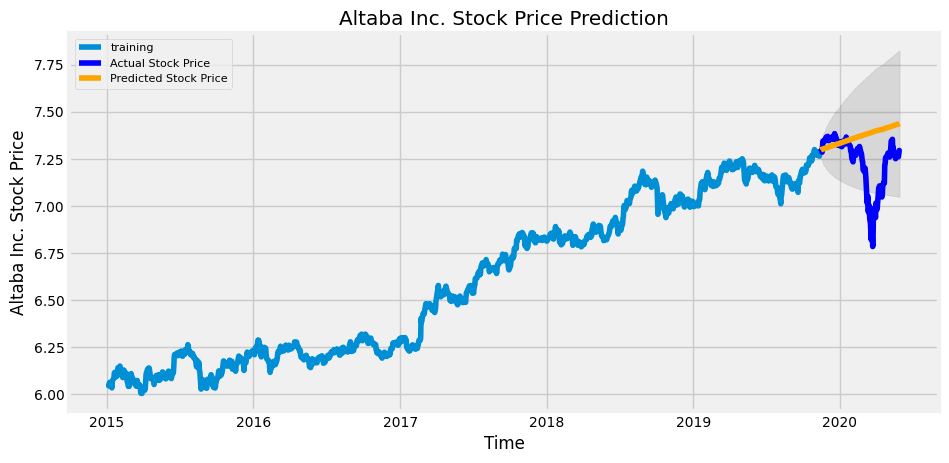

In [30]:
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Reliance industries Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Altaba Inc. Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [31]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))
#Around 3.5% MAPE implies the model is about 96.5% accurate in predicting the next 15 observations.

MSE: 0.04227446442914874
MAE: 0.14387109392945238
RMSE: 0.20560754954317398
MAPE: 0.020267533594088335


Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-6455.717, BIC=-6445.548, Time=0.188 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-6455.974, BIC=-6440.721, Time=0.175 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-6455.789, BIC=-6440.537, Time=0.393 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-6452.629, BIC=-6447.545, Time=0.117 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-6455.695, BIC=-6435.358, Time=0.576 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-6454.631, BIC=-6434.294, Time=0.419 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=-6453.653, BIC=-6428.232, Time=0.513 seconds
Total fit time: 2.401 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1194
Model:               SARIMAX(1, 1, 0)   Log Likelihood                3230.987
Date:                Sun, 07 Ju

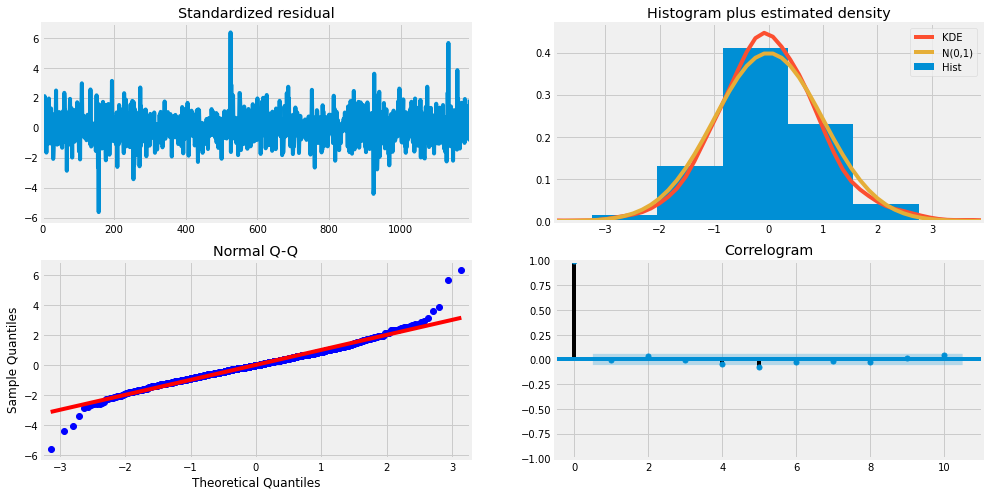

In [32]:
#Auto arima gives the value of p,q,d as 3,1,2
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()
